In [60]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt

****
# Import Datasets
****

In [2]:
path_001 = '../data/Project1 Data export_001.tsv'
path_002 = '../data/Project1 Data export_002.tsv'
path_003 = '../data/Project1 Data export_003.tsv'
path_004 = '../data/Project1 Data export_004.tsv'
path_005 = '../data/Project1 Data export_005.tsv'
path_list = [path_001, path_002, path_003, path_004, path_005]

In [3]:
# Read the tsv file and return the dataframe
def read_tsv(path):
    df = pd.read_csv(path,sep='\t')
    expected_tasks = [f"Task {i}" for i in range(1, 7)]
    task_counts = df['Event'].value_counts()
    for task in expected_tasks:
        if task not in task_counts or task_counts[task] != 6:
            # raise ValueError(f"Mislabeling detected: '{task}' has {task_counts.get(task, 0)} occurrences instead of 6.")
            print(f"Mislabeling detected for file {path}: '{task}' has {task_counts.get(task, 0)} occurrences instead of 6.")
    return df


def pad_or_truncate_nan(ts, target_length):
    """
    Pads (or truncates) a 1D time-series array 'ts' with NaN 
    to make it exactly 'target_length' long.
    """
    # Create an array of NaNs
    padded = np.full(shape=(target_length,), fill_value=-1)
    length = min(len(ts), target_length)
    padded[:length] = ts[:length]  # copy up to target_length
    return padded

In [4]:
all_files = []
for i in range(len(path_list)):
    file = read_tsv(path_list[i])
    all_files.append(file)


C:\Users\kruu\AppData\Local\Temp\ipykernel_23824\2084261222.py:3: DtypeWarning: Columns (76) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path,sep='\t')


****
# Task range identification
****

In [ ]:
# The frequency of recording is 120Hz, that's why consecutive timestamps are at least 8.33ms apart
(all_files[0]["Recording timestamp"].diff()/1e6).value_counts()

In [5]:
# The unit of the timestamp is in microsecond
#Duration of the screen recording in minutes
print(f"Duration of screen recording in min: {(all_files[0].query('Event == "ScreenRecordingEnd"')['Recording timestamp'].values - all_files[0].query('Event == "ScreenRecordingStart"')['Recording timestamp'].values).item()/(1e6 * 60)}")

#Total duration of the recording in minutes (unit of the columns, miliseconds)
print(f"Total duration in min: {all_files[0]["Recording duration"].unique().item()/(1000*60)}")

Duration of screen recording in min: 18.937161516666666
Total duration in min: 20.649416666666667


In [ ]:
# Get the task range start and end index
def task_range_finder(db, task_str):
    task_range = []
    all_start = db.loc[db['Event'].str.contains('Task', na=False)]["Recording timestamp"].to_list()
    start_task = db.loc[db['Event'] == task_str, 'Recording timestamp'].to_list()
    for j in range(len(all_start)):
        if all_start[j] in start_task:
            # If the last task is the last task of the recording: add 1 minute to the end of the task
            if j == len(all_start) - 1:
                task_range.append([all_start[j], all_start[j] + (60*1e6)])
            else:
                task_range.append([all_start[j], all_start[j+1] - (5*1e6)])
    return task_range

In [35]:
# Average task duration per person in seconds
tasks = ['Task 1', 'Task 2', 'Task 3', 'Task 4', 'Task 5', 'Task 6']
durations = {task: [] for task in tasks}
for file in all_files:
    for task in tasks:
        task_range = task_range_finder(file, task)
        durations[task].append(round(np.mean([x[1] - x[0] for x in task_range]).item()/(1e6), 2))
durations

{'Task 1': [38.02, 27.98, 32.42, 33.69, 18.53],
 'Task 2': [19.13, 16.49, 16.7, 12.83, 13.14],
 'Task 3': [19.47, 21.36, 25.66, 21.86, 19.22],
 'Task 4': [28.85, 14.59, 19.47, 20.3, 16.11],
 'Task 5': [24.34, 18.97, 21.38, 19.47, 16.47],
 'Task 6': [28.98, 18.67, 20.09, 16.68, 15.65]}

****
# Data Extraction
****

In [ ]:
# Min-Max transform
def min_max_safe_transform(arr):
    if arr.shape[0] == 0:
        # Return empty 1D array if no samples
        return np.array([])
    # Fit a new scaler for each array
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(arr)  # shape => (rows, 1)
    return scaled.ravel() 

# Get the gaze point and mouse position data
def feature_extraction(db, task_range):

    for period in task_range:
        data = db.query(f"`Recording timestamp` >= {period[0]} and `Recording timestamp` <= {period[1]}")[['Gaze point X', 'Gaze point Y', 'Mouse position X', 'Mouse position Y']]
        data_filled = data.ffill().bfill()
        

I'm not sure that it is a good idea to just drop the nans for each columns separately. Then we modify the lenghts of each sensor, and we loose the time adequacy from one sensor to another

In [118]:
gaze = db.query(f"`Recording timestamp` >= {task_range_1[0][0]} and `Recording timestamp` <= {task_range_1[0][1]}")[['Gaze point X', 'Gaze point Y', 'Mouse position X', 'Mouse position Y']]

# Longest period of nans in each column
def longest_nan_period(db):
    longest_nan = {}
    for col in db.columns:
        longest_nan[col] = 0
        nan_count = 0
        for i in range(len(db)):
            if pd.isna(db[col].iloc[i]):
                nan_count += 1
            else:
                if nan_count > longest_nan[col]:
                    longest_nan[col] = nan_count
                nan_count = 0
    return longest_nan

#list of all nan periods
def nan_period(db):
    periods_nan = {}
    for col in db.columns:
        nan_count = 0
        for i in range(len(db)):
            if pd.isna(db[col].iloc[i]):
                nan_count += 1
            else:
                if nan_count != 0:
                    if col not in periods_nan:
                        periods_nan[col] = [nan_count]
                    else:
                        periods_nan[col].append(nan_count)
                nan_count = 0
    return periods_nan

longest_nan_period(gaze)

{'Gaze point X': 637,
 'Gaze point Y': 637,
 'Mouse position X': 110,
 'Mouse position Y': 110}

In [107]:
# We fill the nans with the previous known value and the next known value if at the begining of the array
gaze_filled = gaze.ffill().bfill()

In [130]:
gaze_filled

,Gaze point X,Gaze point Y,Mouse position X,Mouse position Y
10741,225.0,146.0,1485.0,20.0
10742,225.0,146.0,1485.0,20.0
10743,225.0,146.0,1485.0,20.0
10744,225.0,146.0,1485.0,20.0
10745,225.0,146.0,1485.0,20.0
...,...,...,...,...
13208,1279.0,1005.0,1801.0,7.0
13209,1297.0,1150.0,1801.0,7.0
13210,1310.0,1302.0,1801.0,7.0
13211,1310.0,1302.0,1801.0,7.0


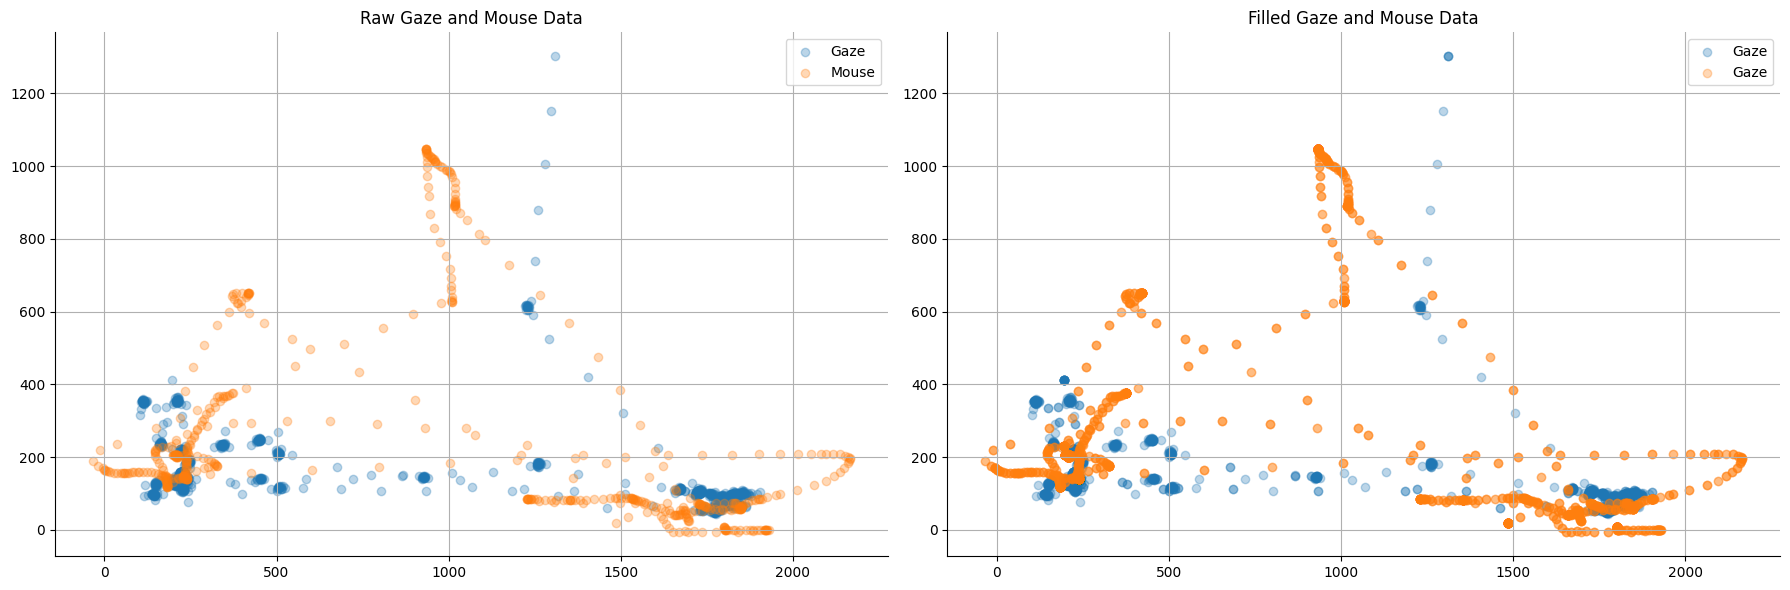

In [112]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6)) 

axes[0].scatter(gaze["Gaze point X"], gaze["Gaze point Y"], label="Gaze", alpha=0.3)
axes[0].scatter(gaze["Mouse position X"], gaze["Mouse position Y"], label="Mouse", alpha=0.3)
axes[0].set_title("Raw Gaze and Mouse Data")
axes[0].legend()
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)
axes[0].grid(True)

axes[1].scatter(gaze_filled["Gaze point X"], gaze_filled["Gaze point Y"], label="Gaze", alpha=0.3)
axes[1].scatter(gaze_filled["Mouse position X"], gaze_filled["Mouse position Y"], label="Mouse", alpha=0.3)
axes[1].set_title("Filled Gaze and Mouse Data")
axes[1].legend()
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)
axes[1].grid(True)

plt.tight_layout()
plt.show()

****
# Padding
****